# Developing an AI application

## Quick Shortcut links
<a href="#library" style="text-decoration: none; font-family: Tahoma; font-size: 16px;">step 01: import the relevant libraries & modules</a><br>
<a href="#load" style="text-decoration: none; font-family: Tahoma; font-size: 16px;">step 02: load the data</a><br>
<a href="#map" style="text-decoration: none; font-family: Tahoma; font-size: 16px;">step 03: map the labels to their natural language descriptions</a><br>
<a href="#build" style="text-decoration: none; font-family: Tahoma; font-size: 16px;">step 04: build and train the classifier</a><br>
&emsp;<a href="#pretrained" style="text-decoration: none; font-family: Tahoma; font-size: 16px;">a. load a pretrained network</a><br>
&emsp;<a href="#untrained" style="text-decoration: none; font-family: Tahoma; font-size: 16px;">b. define a new untrained feed-foward network</a><br>
&emsp;<a href="#backprop" style="text-decoration: none; font-family: Tahoma; font-size: 16px;">c. train the classified layers using backpropagation</a><br>
<a href="#test" style="text-decoration: none; font-family: Tahoma; font-size: 16px;">step 05: test the network</a><br>
<a href="#save" style="text-decoration: none; font-family: Tahoma; font-size: 16px;">step 06: save the checkpoint</a><br>
<a href="#resume" style="text-decoration: none; font-family: Tahoma; font-size: 16px;">step 07: load the checkpoint</a><br>
<a href="#process" style="text-decoration: none; font-family: Tahoma; font-size: 16px;">step 08: process the input image</a><br>
<a href="#predict" style="text-decoration: none; font-family: Tahoma; font-size: 16px;">step 09: make a prediction using the trained model</a><br>
<a href="#plot" style="text-decoration: none; font-family: Tahoma; font-size: 16px;">step 10: sanity checking</a><br>

<a id='library'></a>
## step 01: import the relevant libraries & modules

In [1]:
import torch                      # import PyTorch library
import torch.nn as nn             # import the 'nn' module from PyTorch
import torch.optim as optim       # import the 'optim' module from PyTorch
import torch.nn.functional as F   # import the 'functional' method from the 'nn' module 

- _nn module has the basic building blocks for neural networks_
- _optim module has optimizers for training neural networks_
- _nn.functional module provides relevant neural network functions which include activation functions, loss functions, and various tensor operations._

In [2]:
import torchvision                           # import PyTorch Vision library
import torchvision.datasets as datasets      # import the 'datasets' module from PyTorch Vision
import torchvision.transforms as transforms  # import the 'transforms' module from PyTorch Vision
import torchvision.models as models          # import the 'models' module from the PyTorch Vision

- _datasets module provides datasets for computer vision tasks_
- _transforms module adjusts images (resizing, cropping, normalizing)_
- _models module provides pre-trained models for computer vision tasks (vgg, resnet, alexnet)_

In [3]:
import numpy as np                   # import the NumPy library
import matplotlib.pyplot as plt      # import the Matplotlib library
import os                            # import the operating system library 
import json
from PIL import Image                # import the image class from the python imaging library
from collections import OrderedDict  # import the OrderedDict class
import random                        # Import the random module to generate random numbers and sequences.

- _NumPy provides a high-level interface to numerical data_
- _Matplotlib is a python plotting API. It contains graph and image plotting functions._
- _the os library provides functions for interacting with the operating system_
- _the OrderedDict collection preserves the order in which elements were added_

In [4]:
# run the workspace_utils python script
# import the relevant utilities
%run workspace_utils.py

In [5]:
# import the keep_awake & active_session functions from the workspace_utils module
# prevent the workspace from timing out during long-running tasks
from workspace_utils import keep_awake, active_session

<a id='load'></a>
## step 02: load the data

In [6]:
data_dir = 'flowers'  # define the data directory
train_dir = os.path.join(data_dir, 'train')  # define the training directory
valid_dir = os.path.join(data_dir, 'valid')  # define the validation directory
test_dir = os.path.join(data_dir, 'test')    # define the test directory

- _the data directory contains the training, validation and test data_
- _the training directory contains images that will be used to train the neural network_
- _the validation directory contains images that will be used to validate the neural network_
- _the test directory cntains images that will be used to test the neural network_

In [7]:
train_transforms = transforms.Compose([               # define the train transforms
                   transforms.RandomRotation(75),     # rotate image by 75 degrees
                   transforms.RandomResizedCrop(224), # resize image 224 by 224 pixels
                   transforms.RandomHorizontalFlip(), # flip the image horizontally
                   transforms.ToTensor(),             # convert image to a PyTorch tensor
                   transforms.Normalize([0.485,       # normalize using required measurements 
                   0.456, 0.406], [0.229, 0.224,
                   0.225])])

- _the compose() function takes a list of transforms as input and applies them to the images in sequence_
- _the RandomHorizontalFlip() function makes the training set more balanced_
- _the PyTorch tensor is the format the neural network expects the images to be in_
- _the Normalize() function sets the mean and standard deviation of the image to 0 and 1 respectively_

In [8]:
def custom_transforms():
    return transforms.Compose([transforms.Resize(200),      # resize the image to 200x200
                               transforms.CenterCrop(224),  # crop the image to 224x224 at the center
                               transforms.ToTensor(),       # convert the image to a PyTorch tensor
                               transforms.Normalize([0.485, # normalize the image
                               0.456,0.406],[0.229, 0.224, 
                               0.225])])

In [9]:
# invoke the 'custom_transforms()' function
# store its value in the 'validation_transforms' variable  
validation_transforms = custom_transforms()

- _the validation image size is larger than the training image size to generalize to images of different sizes_
- _the validation transforms make the validation set more consistent with the test set_

In [10]:
# invoke the 'custom_transforms()' function
# store its value in the 'test_transforms' variable
test_transforms = custom_transforms()

- _the test transforms make the test set more consistent with the training set_

In [11]:
def load_datasets():
    """loads the train, validation, and test datasets with ImageFolder"""
    
    image_datasets = []
    
    # Iterate over the dataset types
    for dataset_type in ["train", "validation", "test"]:
        
        # Create an ImageFolder object for the current dataset
        if dataset_type == "train":
            dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
        elif dataset_type == "validation":
            dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)
        elif dataset_type == "test":
            dataset = datasets.ImageFolder(test_dir, transform=test_transforms)
        
        # Add the datasets to the image_datasets list
        image_datasets.append(dataset)
        
    return image_datasets

- _the load-datasets() function uses a list comprehension to create the image-datasets lists._
- _The list comprehension iterates over the three dataset types._
- _It creates a 'datasets.ImageFolder' object for each dataset type._
- _The transforms name object is also created using a list comprehension._

In [12]:
# load the image datasets using the defined function load_datasets()
# store the result in the variable image_datasets
image_datasets = load_datasets()

- _train-dir, valid-dir and test-dir arguments specify where the train, validation and training images are stored_
- _all the different transforms arguments specify the transformations to be applied onto the respective images_
- _the train, validation and the test datasets are created using the 'datasets.ImageFolder' class_

In [13]:
# create an empty list to store the data loaders
dataloaders = []

# iterate over the image datasets
for i in range(len(image_datasets)):
    
    # create a data loader for the current dataset
    dataloader = torch.utils.data.DataLoader(image_datasets[i], batch_size=32, shuffle=True)
    
    # add the data loader to the list of data loaders
    dataloaders.append(dataloader)

- _the code uses a list comprehension to iterate over the image datasets list._
- _it creates a 'torch.utils.data.DataLoader' object for each dataset._
- _the batch size and shuffle arguments are set to '32' and 'True' respectively._

<a id='map'></a>
## step 03: map the labels to their natural language descriptions

In [14]:
# open the file 'cat_to_name.json' in read mode
# load its contents into the dictionary 'cat_to_name'
cat_to_name = json.load(open('cat_to_name.json', 'r'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


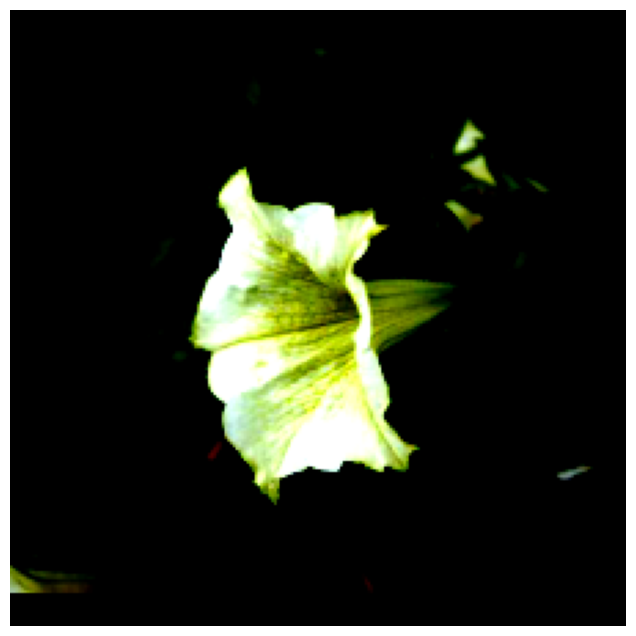

In [15]:
# Select the test dataloader (dataloaders[2])
test_dataloader = dataloaders[1]

# Get a batch of data from the test dataloader
data_iter = iter(test_dataloader)
images, labels = next(data_iter)

# Display an image from the batch
plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(images[0], (1, 2, 0)))  # Transpose the image tensor to (H, W, C)
plt.axis('off')
plt.show();

- _(H, W, C) : - Height(vertical dimension), Width(horizontal dimension), Color channels in image_
- _The code snippet selects a batch of data from the test dataloader and displays an image from the batch._ 
- _The test dataloader is a collection of data that is used to evaluate the performance of a trained model._
- _The image is a vibrant tapestry of colors and shapes, but its true meaning is still hidden._
- _The trained model will soon be tasked with unlocking the image's secrets and revealing the hideen truths within._

<a id = 'build'></a>
## step 04: build and train the classifier

In [16]:
# check if the gpu is enabled 
if torch.cuda.is_available():        
    
    # set the device to CUDA if the condition returns True
    device = torch.device("cuda")    

else:
    
    # set the device to CPU if the function returns False
    device = torch.device("cpu")
    
    # print a notice statement of switching the engine operator 
    # to notify the usera about the changes      
    print("GPU disabled. Switching  engine operator ...")                             

- _CUDA stands for "Compute Unified Device Architecture"_
- _It is a parallel computing platform and application programming interface (API) created by NVIDIA._
- _CUDA allows developers to use NVIDIA GPUs (Graphics Processing Units) for general-purpose processing tasks, not just for rendering graphics_

<a id='pretrained'></a>
### a. load a pre-trained network

In [155]:
# import the vgg16 model from the 'torchvision.models' alias 'models' module
# command the function to use the pre-trained weights
model = models.vgg16(pretrained = True);

- _the 'pre-trained=True' argument indicates that we are bound to use the pre-trained weights which will speed up the training process_ 

<a id='untrained'></a>
### b. define a new untrained feed-forward network

In [156]:
# disable gradient computation for each parameter in the model 
for param in model.parameters():
    param.requires_grad = False

- _model.parameters() is a reference to all the parameters (learnable weights and biases) contained within a PyTorch model_

In [157]:
# define the new classifier
new_classifier = nn.Sequential(OrderedDict([                         # define a new classifier with three fully connected layers
           ('fc1', nn.Linear(25088, 1536)),                          # insert 25088 inputs and 1536 outputs in the first layer 
           ('relu1', nn.ReLU()),                                     # invoke the ReLU activation function after the first layer 
           ('dropout1', nn.Dropout(0.4)),                            # drop 40% of the inputs
           ('l2_reg', nn.LayerNorm(1536, elementwise_affine=False)), # apply L2 regulaization to the first layer output
           ('fc2', nn.Linear(1536, 256)),                            # insert 1536 inputs and 256 outputs in the second layer
           ('relu2', nn.ReLU()),                                     # invoke the ReLU activation function after the second layer
           ('fc3', nn.Linear(256, 102)),                             # insert 256 inputs and 102 outputs in the third layer
           ('output', nn.LogSoftmax(dim=1))                          # convert the outputs to probabilities
            ]))

- _the dropout layer randomly drops 40% of the inputs to prevent overfitting_
- _the L2 regularization adds a penalty to the weights that are large in magnitude_
- _the 'elementwise-affine=False' argument ensures that no learnable affine transformation is applied after transformation_ 

In [158]:
model.classifier = new_classifier                                     # update and replace the classifier in the model

In [20]:
def learning_rate_scheduler(optimizer, epoch):
    """
    A learning rate scheduler that adds 0.005 to the learning rate after 7 epochs.
    
    Args:
        optimizer: The optimizer to use.
        epoch: The current epoch.
    """
    # get the current learning rate from the optimizer's parameters
    lr = optimizer.param_groups[0]["lr"]
    if epoch > 7:
        lr = lr + 0.005
    optimizer.param_groups[0]["lr"] = lr

In [21]:
model.to(device=device)                                                # move the model to the appropriate device (GPU or CPU)
criterion = nn.NLLLoss()                                               # define the criterion
optimizer = optim.Adam(params=model.classifier.parameters(), lr=0.01)  # define the optimizer

- _a classifier is a part in a machine learning model which takes features (input data) and makes predictions_
- _modern machine learning often utilizes GPUs for faster computations_
- _a criterion / loss function measures how far the model's predictions are from the actual target values_
- _an optimizer adjusts the model's weights based on the calculated loss, aiming to minimize it._

<a id="backprop"></a>
### c. train the classifier layers using backpropagation

In [22]:
# training settings
epoch = 0
num_epochs = 10        # set how many times the entire dataset will be used for training
logging_interval = 80  # set how many times an update on progress will be shown 
steps = 0              # set a counter to keep track of how far we are in training

- _the model is set to learn patterns in the data through a ten round training loop_
- _for every 80 steps, an update will be shared on its progress (how well it's doing)_

In [23]:
scheduler = learning_rate_scheduler(optimizer, epoch) # create a learning rate scheduler

- _This code creates a learning rate scheduler._ 
- _A learning rate scheduler is a technique that is used to adjust the learning rate of an optimizer during training._
- _This can be useful for improving the performance of the model._
- _The learning-rate-scheduler() function takes two arguments: the optimizer which is being used to train the model and the current epoch._

<div class = "alert alert-block alert-info" style="font-fmily: Arial; font-size: 16px;"><span style="color: black;"><b>When training the model, I kept saving the checkpoint to a checkpoint_filename variable for each epoch.<br><br>This happened towards the end of each epoch before crossing over into a new one.<br><br>Therefore, in the event of a 'cuda out-of-memory error', 'power blackout', 'unstable internet', 'a hang operating system'.<br><br>The training would come to a halt and I would reload the model from its last saved dictionary state to resume.<br><br>This explains why my validation accuracy starts with an 86% in the first epoch.</b></span>

In [ ]:
# Training loop
for epoch in range(num_epochs):
    
    # Initialize the running loss
    running_loss = 0
    
    # with an active session method invoked
    # please proceed to perform the operations below
    with active_session():

        # Iterate over the training data loader
        for inputs, labels in dataloaders[0]:  # Use dataloaders[0] for the training dataset
        
            # Increment the step counter
            steps += 1
        
            # Move the inputs and labels to the specified device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)
        
            # Reset the gradients
            optimizer.zero_grad()
        
            # Forward pass through the model
            outputs = model(inputs)
        
            # Compute the loss
            loss = criterion(outputs, labels)
        
            # Backpropagate the loss
            loss.backward()
        
            # Update the parameters
            optimizer.step()
        
            # Accumulate the running loss
            running_loss += loss.item()
        
            # If the step number is divisible by the logging interval,
            # evaluate the model on the validation set and print the results
            if steps % logging_interval == 0:
            
                # Set the model to evaluation mode
                model.eval()
            
                # Disable gradient calculation
                with torch.no_grad():
                
                    # Initialize validation loss and accuracy
                    val_loss = 0
                    val_accuracy = 0
                
                    # Iterate over the validation data loader (dataloaders[1])
                    for val_inputs, val_labels in dataloaders[1]:
                        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    
                        # Calculate validation loss
                        val_outputs = model(val_inputs)
                        val_loss += criterion(val_outputs, val_labels).item()
                    
                        # Calculate validation accuracy
                        val_ps = torch.exp(val_outputs)
                        val_equality = (val_labels.data == val_ps.max(dim=1)[1])
                        val_accuracy += val_equality.type(torch.FloatTensor).mean()
                
                    # Calculate average validation loss and accuracy
                    validation_loss = (val_loss / len(dataloaders[1]))*100
                    validation_accuracy = (val_accuracy / len(dataloaders[1]))*100
                    
                    # Calculate the train loss
                    train_loss = (running_loss/logging_interval)*100
                
                # Print the training and validation metrics
                print(f"Epoch: {epoch+1}/{num_epochs}   " , 
                      f"Train loss: {train_loss:.1f}%   " , 
                      f"Validation loss: {validation_loss:.1f}%   " , 
                      f"Validation accuracy: {validation_accuracy:.1f}%")
            
                # check num_epochs and update the learning rate if the set condition is True
                scheduler
            
                # save the checkpoint dictionary to the file named 'checkpoint_filename'
                torch.save(checkpoint, checkpoint_filename)
            
                # Reset the running loss
                running_loss = 0
            
                # Set the model back to training mode
                model.train()

Epoch: 1/10    Train loss: 35.6%    Validation loss: 80.5%    Validation accuracy: 86.0%
Epoch: 1/10    Train loss: 45.0%    Validation loss: 78.3%    Validation accuracy: 87.1%
Epoch: 2/10    Train loss: 19.4%    Validation loss: 72.9%    Validation accuracy: 88.4%
Epoch: 2/10    Train loss: 47.7%    Validation loss: 77.9%    Validation accuracy: 87.4%
Epoch: 2/10    Train loss: 46.1%    Validation loss: 74.3%    Validation accuracy: 87.8%
Epoch: 3/10    Train loss: 40.5%    Validation loss: 77.5%    Validation accuracy: 87.3%
Epoch: 3/10    Train loss: 46.9%    Validation loss: 91.6%    Validation accuracy: 87.1%
Epoch: 4/10    Train loss: 11.8%    Validation loss: 72.7%    Validation accuracy: 88.5%
Epoch: 4/10    Train loss: 47.3%    Validation loss: 70.4%    Validation accuracy: 88.7%
Epoch: 4/10    Train loss: 49.8%    Validation loss: 77.9%    Validation accuracy: 88.0%
Epoch: 5/10    Train loss: 34.9%    Validation loss: 73.7%    Validation accuracy: 88.5%
Epoch: 5/10    Train 

- _the training loop initializes the running loop to 0 and iterates over the training data loader_
- _for each data batch, the training loop increments the step counter, moves the inputs and labels to the specified device_
- _the training loop resets the gradients, performs a forward pass through the model, computes the loss, backpropagates the loss, updates the parameters_
- _the training loop also accumulates the running loss._ 
- _If the step number is divisible by the logging interval, the code evaluates the model on the validation set and prints the results_
- _the loop then resets the running loss and sets the model back to training mode_

<a id="test"></a>
## step 05: test the network

In [26]:
def evaluate(model, test_loader):
    """
    Evaluates the model on the test set.
    
    Args:
        model: the model to evaluate.
        test_loader: the test data loader.
        
    Retruns:
        The test accuracy.
    """
    # initialize the variables
    correct_predictions = 0      # number of correct predictions
    total_samples = 0            # total number of samples
    
    # temporarily turn off the gradient calculation
    # set the model to evaluation mode
    model.eval()
    
    # iterate over the test data
    for inputs, labels in test_loader:
        
        # move the inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # forward pass
        outputs = model(inputs)
        
        # get the predictions
        _, predicted = torch.max(outputs.data, 1)
        
        # update the counters
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
    # return the accuracy
    return 100*correct_predictions / total_samples

In [27]:
# calculate the test accuracy
test_accuracy = evaluate(model, dataloaders[2])

# print the test accuracy
print(f' Test set accuracy: {test_accuracy:.2f}%')

 Test set accuracy: 85.35%


- _The evaluate function evaluates the performance of a trained model on a test set._
- _The function first initializes two variables to track the number of correct predictions and the total number of samples._
- _The function then sets the model to evaluation mode, which disables certain features of the model that are used during training._
- _The function then iterates over the test set, and for each data batch, it moves the inputs and labels to the specified device (GPU or CPU)_
- _The function then performs a forward pass through the model and gets the predictions from the model._ 
- _The function then updates the counters for the number of correct predictions and the total number of samples_
- _The function finally returns the accuracy which is a percentage of the number of correct predictions_

<a id="save"></a>
## step 06: save the checkpoint

In [24]:
# save the checkpoint

# assign the class_to_idx attribute of the first image dataset to the model
model.class_to_idx = image_datasets[0].class_to_idx

checkpoint = {                                           # create a dictionry called 'checkpoint'
            'input_size'      : 25088,                   # the input size of the model
            'output_size'     : 1536,                    # the output size of the model
            'arch'            : 'vgg16',                 # the architecture of the model
            'classifier'      : model.classifier,        # the classifier component of the model
            'learning_rate'   : 0.001,                   # the learning rate used to train the model
            'batch_size'      : 32,                      # the batch size used to train the model
            'num_epochs'      : num_epochs,              # the number of epochs used to train the model 
            'class_to_idx'    : model.class_to_idx,      # the 'class_to_idx' attribute of the model
            'state_dict'      : model.state_dict(),      # the state dictionary of the model 
            'optimizer_state' : optimizer.state_dict()   # the optimizer state of the model 
            }

In [17]:
# create a variable called 'checkpoint_filename'
# the variable stores the name of the file where the checkpoint will be saved 
checkpoint_filename = 'trained_model_checkpoint.pth'

In [42]:
# save the checkpoint dictionary to the file named 'checkpoint-filename'
torch.save(checkpoint, checkpoint_filename)

# print a message to the console to report that the checkpoint has been saved
print (f"Checkpoint saved to '{checkpoint_filename}'. You're ready for further training !")

Checkpoint saved to 'trained_model_checkpoint.pth'. You're ready for further training !


- _the relevance of the code block above is to save the state of a trained model to a file_
- _this will be used to resume training from a previous checkpoint_
- _it can also be used to load the model to make predictions on new data_
- _assigning the 'class-to-idx' means that the model now knows how to map each class label to an integer_

<a id="resume"></a>
## step 07: load the checkpoint

In [18]:
def rebuild_model_from_checkpoint(file_path_variable):
    
    """
    load a checkpoint from a file_path_variable and rebuild the model when using GPU
    
    Args: 
        file_path_variable (str): the path to the checkpoint file
    
    Returns: the model
    
    """
    # load the chekpoint from the file_path_variable
    checkpoint = torch.load(file_path_variable, map_location=torch.device("cuda"))
    
    # get the model architecture from the checkpoint
    arch = checkpoint['arch']
    
    # create a new model instance of the specified architecture
    model = getattr(torchvision.models, arch)(pretrained = True)
    
    # replace the model classifier with the classifier from the checkpoint
    model.classifier = checkpoint["classifier"]
    
    # load the model state dict from the checkpoint
    model.load_state_dict(checkpoint["state_dict"])
    
    return model


- _the getattr() function in the code is used to get the model architecture from the checkpoint_
- _the checkpoint-state-dict variable stores the model state dict from the checkpoint_
- _the model-load-state-dict function is then used to load model state dict into the model variable_

In [19]:
# load the checkpoint from the file_path_variable_name : checkpoint_filename
model = rebuild_model_from_checkpoint(checkpoint_filename)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/student/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 73.5MB/s] 


<a id="process"></a>
## step 08: process the input image

In [25]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # open the image using PIL
    img = Image.open(image_path)
    
    # define transformations for image preprocessing 
    preprocess =  transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    # apply the defined transformations
    img_tensor = preprocess(img)
    
    return img_tensor

- _The Python Imaging Library (PIL) is a free and open-source library that adds image processing capabilities to the Python programming language._ 
- _It is a powerful and versatile library that can be used for a wide range of image processing tasks._
- _Some of these tasks include reading and writing image files in a variety of formats, including JPEG, PNG, BMP, and TIFF._
- _Converting images between different formats._
- _Performing basic image operations such as resizing, cropping, rotating, and flipping._
- _Applying advanced image processing techniques such as filtering, sharpening, and edge detection._

In [26]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

- _The purpose of the method above is to display a PyTorch tensor as an image using Matplotlib._ 
- _The code block does this by: - transposing the tensor so that the color channel is the third dimension, as expected by Matplotlib._
- _It also Undoes the preprocessing that was applied to the tensor when it was loaded._
- _It clips the tensor values to be between 0 and 1, so that the image is displayed correctly._
- _It displays the image using Matplotlib._
- _The code block also returns the Matplotlib axis object that the image is displayed on._ 
- _This can be useful for further customization of the image, such as adding a title or axis labels._

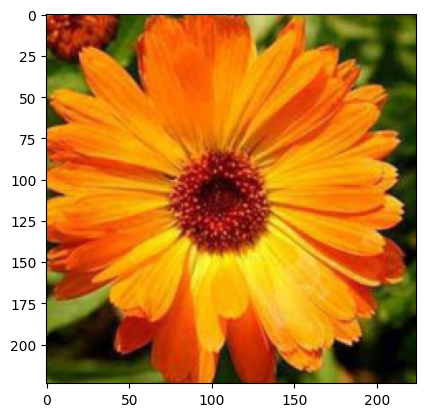

In [27]:
# load image_05159.jpg

# process and display it using the relevant defined functions

imshow(process_image('flowers/test/5/image_05159.jpg'));

<a id="predict"></a>
## step 09: make a prediction using the trained model

In [35]:
def predict(image_path, model, topk=5, device="cuda"):
    """
    Predict the class (or classes) of an image using a trained deep learning model.

    Args:
        image_path: The file path of the image to predict.
        model: The trained deep learning model.
        topk: The number of top predictions to return (default is 5).
        device: The device to use for inference (default is "cuda").

    Returns:
        Tuple containing the topk probabilities and predicted flower names.
    """
    # Process the image
    image = process_image(image_path)
    image = image.unsqueeze(0)

    # Move the image to the specified device (GPU or CPU)
    image = image.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient calculation
    with torch.no_grad():
        # Calculate the probability distribution over the classes
        ps = torch.exp(model(image))

    # Map class indices to flower names
    idx_to_flower = {v: cat_to_name[k] for k, v in model.class_to_idx.items()}

    # Get the topk most likely classes and convert them to flower names
    top_ps, top_classes = ps.topk(topk, dim=1)
    predicted_flowers = [idx_to_flower[i] for i in top_classes.tolist()[0]]

    return top_ps.tolist()[0], predicted_flowers

In [36]:
# Define the path to the image you want to predict
image_path = "flowers/test/11/image_03147.jpg"

# Use the 'predict' function to get probabilities and classes
probability, classes = predict(image_path, model)

# Print the predicted probabilities
print(probability)

# Print the predicted classes
print(classes)

[0.641503095626831, 0.3439381718635559, 0.012916265055537224, 0.0014630845980718732, 9.822643187362701e-05]
['snapdragon', 'wallflower', 'primula', 'rose', 'globe-flower']


## sample code 

In [33]:
#def predict(image_path, model, topk=5, device="cuda"):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    #image = process_image(image_path)
    #image = image.unsqueeze(0)

    # move to device
    #image = image.to(device)
    #model.eval()
    #with torch.no_grad():
        #ps = torch.exp(model(image))
        
    #idx_to_flower = {v: cat_to_name[k] for k, v in model.class_to_idx.items()}    
    
    #top_ps, top_classes = ps.topk(topk, dim=1)
    
    # Modify the following line to return class indices instead of flower names
    #predicted_classes = [idx.item() for idx in top_classes[0]]

    #return top_ps.tolist()[0], predicted_classes


<a id="plot"></a>
## step 10: sanity checking

In [38]:
def classify_random_image():
    """Classifies a random image from the test folder and displays the results."""

    # pick a random image from the test folder.
    random_label_idx = random.choice(os.listdir(test_dir))
    
    # pick a random label index from the list of all the labels in the test directory.
    random_image_file = random.choice(os.listdir("{}/{}".format(test_dir, random_label_idx)))
    
    # picks a random image file from the directory of images with the same label as the random label index.
    image_path = os.path.join(test_dir, random_label_idx, random_image_file)
    
    # join the test directory path, the random label index, and the random image file to create the full path to the image.
    actual_flower_name = cat_to_name[random_label_idx]
    
    # get the actual flower name from the dictionary of category names, using the random label index as the key.

    # process the image.
    image = process_image(image_path)
    
    # process the image using the `process_image()` function.

    # predict the class of the image.
    top_ps, top_classes = predict(image_path, model)
    # predict the class of the image using the `predict()` function.

    # get the top prediction.
    top1_flower_name = top_classes[0]
    # get the top prediction from the list of predicted classes.

    # determine whether the image was classified correctly.
    classified_correctly = "Yes, Top Prediction" if top1_flower_name == actual_flower_name else (
        "Yes in Top 5 Prediction" if actual_flower_name in top_classes else "No")    
    # determine whether the image was classified correctly by comparing the top prediction to the actual flower name.

    # Display the results.
    plt.barh(top_classes, top_ps)
    
    # plot a bar chart of the top predictions.
    plt.title("Actual Class = {} \n Correctly Classified = {}".format(actual_flower_name, classified_correctly))
    
    # set the title of the plot.
    plt.show()
    
    # display the plot.
    imshow(image)
    # display the image.

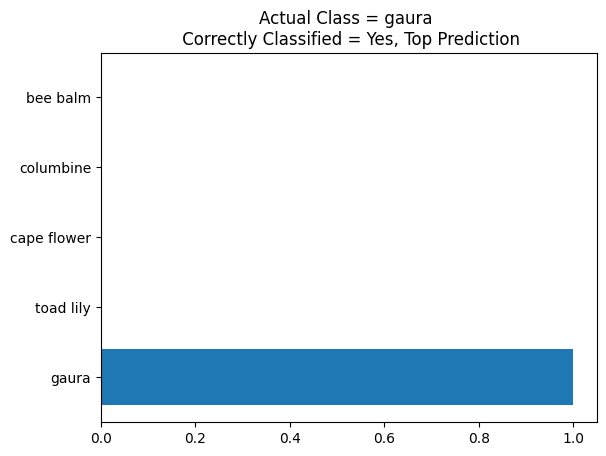

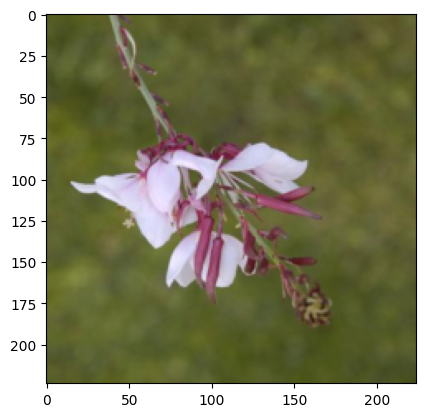

In [39]:
# invoke the defined plot function
classify_random_image()